## Detailed article explaination

The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/541281/multivariate-stock-price-prediction-with-transformer-encoder-in-tensorflow

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57


## Importing Required Libraries and Datasets

In [1]:
!pip install keras-nlp

In [2]:
import yfinance as yf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras_nlp.layers import TransformerEncoder
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend


In [3]:
# Define the ticker symbol for the stock
ticker_symbol = "GOOG"  # Example: Apple Inc.

# Define the start and end dates for the historical data
date_string = "02-Dec-2023"
end_date = datetime.strptime(date_string, "%d-%b-%Y")
start_date = end_date - timedelta(days=5 * 365)  # 5 years ago

# Retrieve historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the historical data as a Pandas DataFrame
print(data.shape)
data.tail()

[*********************100%%**********************]  1 of 1 completed
(1258, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-27,137.570007,139.630005,137.539993,138.050003,138.050003,17886400
2023-11-28,137.630005,138.660004,137.039993,138.619995,138.619995,17046900
2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
2023-11-30,136.399994,136.960007,132.789993,133.919998,133.919998,29913500
2023-12-01,133.320007,133.500000,132.151993,133.320007,133.320007,24258400


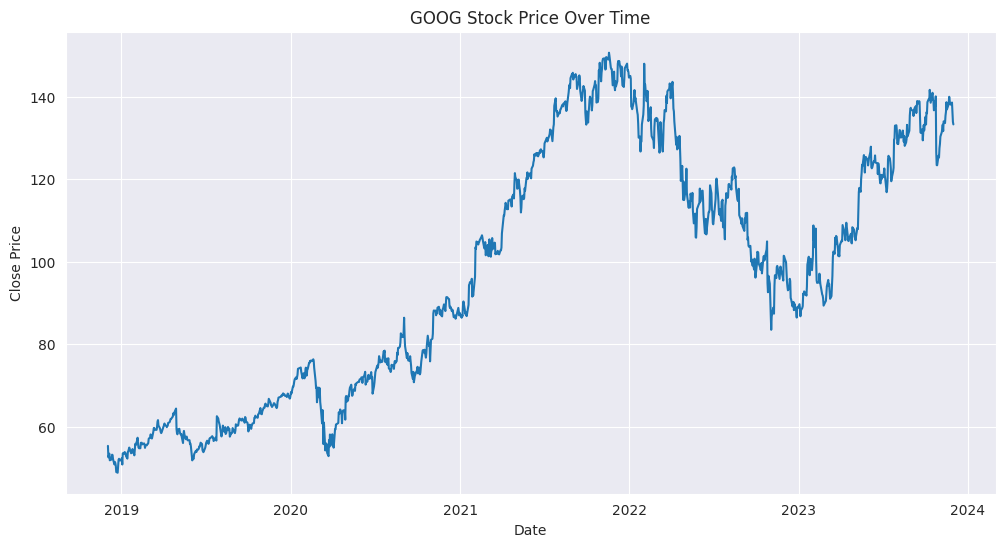

In [4]:

plt.figure(figsize=(12, 6))
sns.set_style('darkgrid')
sns.lineplot(x=data.index, y=data['Close'])

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{ticker_symbol} Stock Price Over Time')

# Show the plot
plt.show()

## Data Preprocessing for Creating Multivariate Time Series

### Dividing the Data into Training and Test Sets

In [5]:
import pandas as pd

# Get the number of records in the DataFrame
total_records = len(data)

# Number of records to keep in the training set
train_size = total_records - 60

# Create the training set
train_data = data.iloc[:train_size]

# Create the test set
test_data = data.iloc[train_size:]

# split each of the training and test sets into features and labels
# Features will include all columns except 'Close'
# Labels will include only the 'Close' column

train_features = train_data.drop('Close', axis=1)
train_labels = train_data['Close']

test_features = test_data.drop('Close', axis=1)
test_labels = test_data['Close']

# Print shapes to confirm
print("Train Features:", train_features.shape, "Train Labels:", train_labels.shape)
print("Test Features:", test_features.shape, "Test Labels:", test_labels.shape)


Train Features: (1198, 5) Train Labels: (1198,)
Test Features: (60, 5) Test Labels: (60,)


### Data Scaling

In [6]:
scaler = MinMaxScaler()

# Fit the scaler to the training features
scaler.fit(train_features)

# Transform the training and test feature sets
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reconstruct dataframes with original columns and indices
train_scaled_df = pd.DataFrame(train_features_scaled, columns = train_features.columns, index = train_features.index)
test_scaled_df = pd.DataFrame(test_features_scaled, columns = test_features.columns, index = test_features.index)

scaler = MinMaxScaler()

# Fit the scaler to the training labels and transform them
train_labels = scaler.fit_transform(train_labels.values.reshape(-1, 1))

# Transform the test labels with the already fitted scaler
test_labels = scaler.transform(test_labels.values.reshape(-1, 1))

### Creating Multivariate Training and Test Sequences

In [7]:
sequence_length = 60

def create_train_sequence(train_df, train_labels, sequence_length):
    seq_length = sequence_length  # Length of the sequence
    features = []  # List to hold feature sequences
    labels = []    # List to hold labels

    # Iterate through the DataFrame to create sequences
    for i in range(seq_length, len(train_df)):
        sequence = train_df.iloc[i-seq_length:i]  # Get 60 days sequence
        label = train_labels[i]                      # Get the label for the corresponding day

        features.append(sequence.values)  # Append sequence to features
        labels.append(label)              # Append label

    # Convert lists to numpy arrays
    X = np.array(features)
    y = np.array(labels).reshape(-1, 1)

    return X, y

In [8]:
X_train, y_train = create_train_sequence(train_scaled_df,
                                         train_labels,
                                         sequence_length)

print(X_train.shape)
print(y_train.shape)

(1138, 60, 5)
(1138, 1)


In [9]:
def create_test_sequence(train_df, test_df, test_labels, seq_length):
    # Concatenate the last part of train features with test features
    combined_features_df = pd.concat([train_df.iloc[-seq_length:], test_df])

    test_features = []  # List to hold test feature sequences
    test_labels_list = []  # List to hold test labels

    # Create sequences for the test set
    for i in range(seq_length, len(combined_features_df)):
        sequence = combined_features_df.iloc[i-seq_length:i]  # Get 60 days sequence
        # Use test_labels for label (assuming test_labels is aligned with test_features_df)
        label = test_labels[i - seq_length] if i < len(test_df) + seq_length else None

        test_features.append(sequence.values)  # Append sequence to test features
        test_labels_list.append(label)         # Append label

    # Remove the None values at the end (if any)
    test_features = [feature for feature, label in zip(test_features, test_labels_list) if label is not None]
    test_labels_list = [label for label in test_labels_list if label is not None]

    # Convert lists to numpy arrays
    X = np.array(test_features)
    y = np.array(test_labels_list).reshape(-1, 1)

    return X, y

X_test, y_test = create_test_sequence(train_scaled_df,
                                      test_scaled_df,
                                      test_labels,
                                      sequence_length)
print(X_test.shape)
print(y_test.shape)

(60, 60, 5)
(60, 1)


## Training a Stock Price Prediction Model with Transformer Encoder

In [10]:

# input shape: (60 time steps, 5 features)
input_layer = Input(shape=(60, 5))

# Transformer Encoder layers
transformer_1 = TransformerEncoder(num_heads=2, intermediate_dim=64)(input_layer)
dropout_1 = Dropout(0.2)(transformer_1)

transformer_2 = TransformerEncoder(num_heads=2, intermediate_dim=64)(dropout_1)
dropout_2 = Dropout(0.2)(transformer_2)

transformer_3 = TransformerEncoder( num_heads=2, intermediate_dim=64)(dropout_2)
dropout_3 = Dropout(0.2)(transformer_3)

# Flatten layer
flatten = Flatten()(dropout_3)

# Dense layers
dense_1 = Dense(200, activation='relu')(flatten)

# Dense layer
dense_2 = Dense(100, activation='relu')(dense_1)

# Output layer with a single neuron
output_layer = Dense(1, activation='linear')(dense_2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 5)]           0         
                                                                 
 transformer_encoder (Trans  (None, 60, 5)             826       
 formerEncoder)                                                  
                                                                 
 dropout (Dropout)           (None, 60, 5)             0         
                                                                 
 transformer_encoder_1 (Tra  (None, 60, 5)             826       
 nsformerEncoder)                                                
                                                                 
 dropout_1 (Dropout)         (None, 60, 5)             0         
                                                                 
 transformer_encoder_2 (Tra  (None, 60, 5)             826   

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=500,
    validation_split=0.2,  # 20% of the data for validation
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
29/29 [==============================] - 12s 39ms/step - loss: 0.1686 - val_loss: 0.0401
Epoch 2/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0656 - val_loss: 0.0109
Epoch 3/500
29/29 [==============================] - 1s 18ms/step - loss: 0.0315 - val_loss: 0.0390
Epoch 4/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0222 - val_loss: 0.0106
Epoch 5/500
29/29 [==============================] - 1s 18ms/step - loss: 0.0157 - val_loss: 0.0142
Epoch 6/500
29/29 [==============================] - 0s 17ms/step - loss: 0.0130 - val_loss: 0.0187
Epoch 7/500
29/29 [==============================] - 0s 16ms/step - loss: 0.0128 - val_loss: 0.0089
Epoch 8/500
29/29 [==============================] - 0s 15ms/step - loss: 0.0121 - val_loss: 0.0106
Epoch 9/500
29/29 [==============================] - 0s 16ms/step - loss: 0.0092 - val_loss: 0.0082
Epoch 10/500
29/29 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.013

## Evaluating Model Performance

In [12]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Print the values
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

2/2 [==============================] - 0s 7ms/step
Mean Squared Error (MSE): 0.0025678165444383786
Mean Absolute Error (MAE): 0.0387130112330789


In [13]:
# converting predictions and targets to actual values

y_test = scaler.inverse_transform(y_test)
y_true = scaler.inverse_transform(predictions)

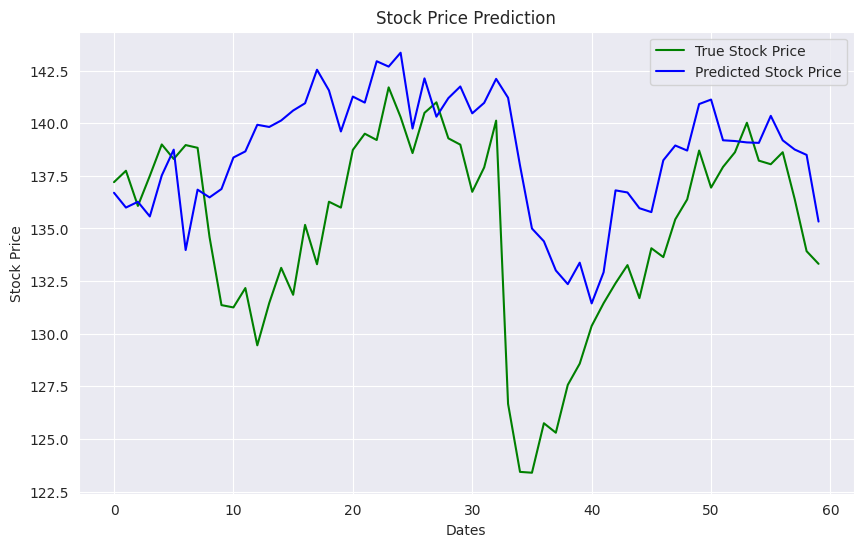

In [14]:
plt.figure(figsize=(10,6))
plt.plot(y_test, color='green', label='True Stock Price')
plt.plot(y_true, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Dates')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
